In [2]:
import util

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [3]:
df_train = pd.read_csv('train.csv', index_col=[0])
df_test = pd.read_csv('test.csv', index_col=[0])

df = pd.concat([df_train, df_test])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


## Data Exploration Notes:
--- 
1. Null values:
    * Age = 263
    * Cabin = 1014 
        * 77% of Cabin data is Null values [Drop / find some utility]  
    * Fare has 1 null value in test training set
2. Text Data:
    * Name
    * Sex
    * Ticket
    * Cabin
    * Embarked
3. Numeric Data:
    * Survived
    * Pclass
    * Age
    * SibSp
    * Parch
    * Fare 
---    
#### Thoughts: ####  
    * Survived mean 0.39, unbalanced Survived ratio?
    * Pclass is skewed more observations with values of 3
    * Age min 0.17 ? 
    * Age mean 30, fairly low considering max value is 80
    * SibSp, Parch and Fare is skewed to the right df.SubSp.hist()
       
#### Value Counts on objects: ####
    * Sex Double the amount of males than females on-board...
    * Name Dubplicates in Test data:  
        * Connolly, Miss. Kate
        * Kelly, Mr. James
    * Tickets lots of values dummy encoding will just make tons of unneeded features...
        * Maybe extract only the numbers and store as int?
        * What about values that don't contain any number?
    * Cabin 186 observations to dummy encode? 
        * Is there a better solution
    * Embarked has 3 Features...
        * Good for dummy encoding however 'S' has triple the amount of occurences than other 2 features combined

In [284]:
df_clean = df.copy()

# Convert sex from object to integer
df_clean.Sex.replace('male', 1, inplace=True)
df_clean.Sex.replace('female', 0, inplace=True)

df_clean['Title'] = [ i.rsplit(', ')[1].rsplit('.')[0] for i in df_clean.Name.values]  # Extract titles

uncommon_titles = 'Rev,Dr,Col,Major,Mlle,Ms,Sir,Capt,Mme,Jonkheer,Lady,the Countess,Don,Dona'.split(',')  
df_clean['Title'] = ['uncommon' if i in uncommon_titles else i for i in df_clean.Title.values]  # Group uncommon titles


# Impute median age for df_clean based on Pclass and Sex
# Todo: tidy code block{
null_age = df_clean[df_clean.Age.isnull()].copy()
for pclass in df_clean.Pclass.unique():
        for gender in df_clean.Sex.unique():
            subset_sex_pclass = df_clean[(df_clean.Sex == gender) & (df_clean.Pclass == pclass)]
            impute_value = round(subset_sex_pclass.Age.median(), 1)
            
            null_age.loc[(df_clean.Sex == gender) & (df_clean.Pclass == pclass), 'Age'] = impute_value
df_clean.loc[null_age.index, 'Age'] = [i for i in null_age.Age.values]
# }

df_clean.Embarked.replace(['S', 'C', 'Q'], [1,2,3], inplace=True)
df_clean.Embarked.fillna(1, inplace=True)

df_clean.drop('Name', axis=1, inplace=True)  # No more 'value' to be extracted from name
df_clean.drop('Cabin', axis=1, inplace=True)  # 77% NaN anyway we can impute data based on fare and title?
df_clean.drop('Ticket', axis=1, inplace=True)  # Unsure of how to use this feature at the moment

df_clean = pd.get_dummies(df_clean, drop_first=True)

train = df_clean[:len(df_train)]
test = df_clean[len(df_train):].drop('Survived', axis=1)

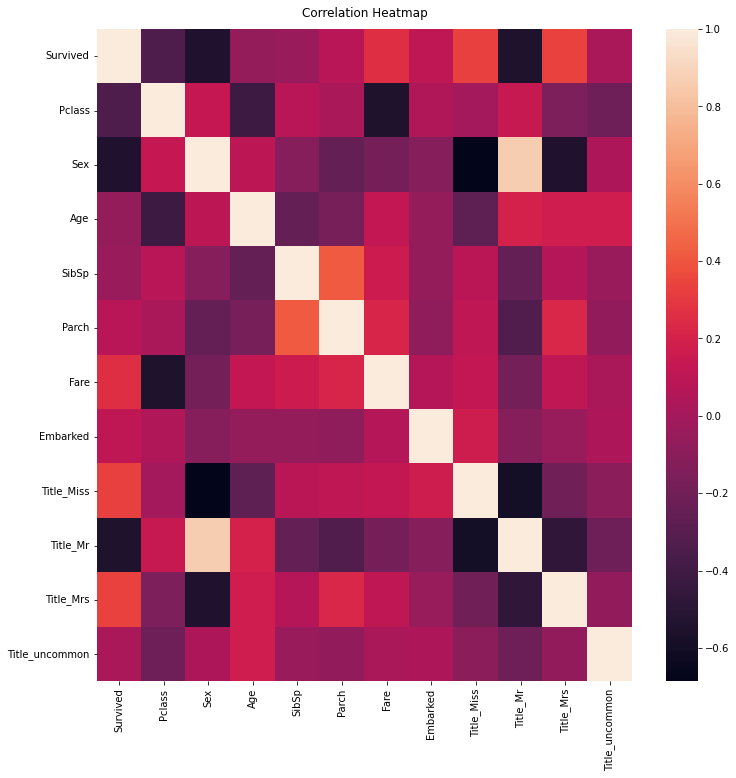

In [173]:
util.plot_heatmap(train)

## Testing model performance

In [174]:
x = train.drop('Survived', axis=1)
y = train.Survived

cv = 10
log_reg_scores = cross_val_score(LogisticRegression(solver='liblinear'), x, y, cv=cv)
tree_classifier_scores = cross_val_score(DecisionTreeClassifier(max_depth=4), x, y, cv=cv)
rand_forest_scores = cross_val_score(RandomForestClassifier(max_depth=10), x, y, cv=cv)
k_neighbors = cross_val_score(KNeighborsClassifier(n_neighbors=5), x, y, cv=cv)

scores_df = pd.DataFrame({
            'LogisticRegression':log_reg_scores,
            'DecisionTreeClassifier':tree_classifier_scores,
            'RandomForestClassifier':rand_forest_scores,
            'KNeighborsClassifier':k_neighbors
                            })
scores_df.describe().drop('count')

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier
mean,0.818177,0.833908,0.823845,0.721685
std,0.037020,0.044189,0.052198,0.030967
min,0.764045,0.741573,0.730337,0.674157
25%,0.800562,0.812297,0.792135,0.701966
50%,0.821223,0.842697,0.831461,0.719101
75%,0.831461,0.862360,0.842697,0.738764
max,0.876404,0.898876,0.921348,0.786517


In [27]:
x.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_uncommon'],
      dtype='object')

Notes:  
* Although slight reduction in mean, the spread of the results has improved

In [269]:
x = train.drop(['Survived', 'Fare', 'Title_Miss', 'Title_Mrs'], axis=1)
y = train.Survived

tree_classifier_scores = cross_val_score(DecisionTreeClassifier(max_depth=4), x, y, cv=cv)
rand_forest_scores = cross_val_score(RandomForestClassifier(random_state=0, max_depth=10), x, y, cv=cv)

scores_df = pd.DataFrame({
            'DecisionTreeClassifier':tree_classifier_scores,
            'RandomForestClassifier':rand_forest_scores,
                            })
scores_df.describe().drop('count')

,DecisionTreeClassifier,RandomForestClassifier
mean,0.836142,0.817116
std,0.042751,0.033906
min,0.752809,0.764045
25%,0.814607,0.803371
50%,0.832397,0.820225
75%,0.865169,0.831461
max,0.898876,0.876404


In [301]:
X = train.drop(['Survived', 'Fare', 'Title_Miss', 'Title_Mrs'], axis=1)
y = train.Survived
Test = test.drop(['Fare', 'Title_Miss', 'Title_Mrs'], axis=1)

tree_model = DecisionTreeClassifier(max_depth=4).fit(X, y)
predicts = tree_model.predict(Test)

submission = pd.DataFrame({'PassengerId': Test.index,
                           'Survived': [int(i) for i in predicts]})

submission.to_csv('DecisionTree_001.csv', index=False)
